In [42]:
import numpy as np
import pandas as pd
from spykes.plot.neurovis import NeuroVis
from spykes.plot.popvis import PopVis
import matplotlib.pyplot as plt
import fklab.plot.core
import fklab.plot.core.utilities
import fklab.plot.plots.plots
import fklab.plot.core.artists
from scipy.stats import binned_statistic


%matplotlib notebook

plt.style.use('seaborn-ticks')

In [43]:
Fs = 30000.0

In [46]:
project_root = '/media/kasia/K/Neuropixeldata/Th1_ca3_9/catgt_29112019_g0/'

clusters = np.load(project_root + "spike_clusters.npy")
#print(clusters)
spike_times = np.load(project_root + "spike_times.npy") / Fs
#print(spike_times)
spike_templates = np.load(project_root + "templates.npy")
y_coords = np.load(project_root + "channel_positions.npy")
#print(y_coords)
spike_clusters = np.load(project_root + "spike_clusters.npy")


In [47]:
dtype = np.dtype([
    ('id', np.int),
    ('Amplitude', np.float),
    ('ContamPct', np.float),
    ('KSLabel', np.dtype('U5')),
    ('amp', np.float),
    ('channel', np.int),
    ('depth', np.float),
    ('firing_rate', np.float),
    ('group', np.dtype('U5')),
    ('n_spikes', np.int),
    ('shank', np.int),
])

data = np.loadtxt(project_root + "cluster_info.tsv",
                 dtype=dtype, skiprows=1, delimiter='\t',
                 converters={7:lambda fr: fr.replace(b' spk/s', b'')})
# print(data)
# print(data['channel'])
#print(data[data['KSLabel'] == 'good'])
all_data_good = data[data['KSLabel']== 'good']
# data_good = data[data['group'] == 'good']
#print(data_good)

In [48]:
all_data_good['depth']

array([3340.,  120.,  120.,  600., 1120., 1380., 1440., 1440., 1460.,
       1560., 1580., 1600., 1600., 1580., 1720., 1680., 1680., 1700.,
       1700., 1700., 1700., 1700., 1740., 1720., 1700., 1800., 1780.,
       1820., 1820., 1840., 1360., 1880., 1840., 2100., 2320.,  340.,
       1860., 1860., 1880.,  520., 1880., 1880., 1880., 1880., 1880.,
       1920., 1920., 1980., 2000., 2020., 2020., 2040., 2060., 2080.,
       2080., 2100., 2100., 2080., 2120., 2140., 2100., 2160., 2160.,
       2180., 2180., 2200., 2200., 2240., 2240., 2300., 2280., 3060.,
       3060., 3080., 3080., 3120., 3140., 3120., 3140., 3180., 3200.,
       3220., 3240., 3260., 3300., 3320., 3340., 3360., 3360., 3400.,
       3380., 3420., 3460., 3480., 3420., 3500., 3480., 3500., 3520.,
       3520., 3520., 3560., 3560., 3580., 3600., 3620., 3660., 3660.,
       3700., 3700., 3700., 3740., 3780., 3800.,  120.,  120.,  600.,
       1160., 1160., 1160., 1160., 1160., 1160., 1580., 1540., 1540.,
       1580., 1600.,

<IPython.core.display.Javascript object>


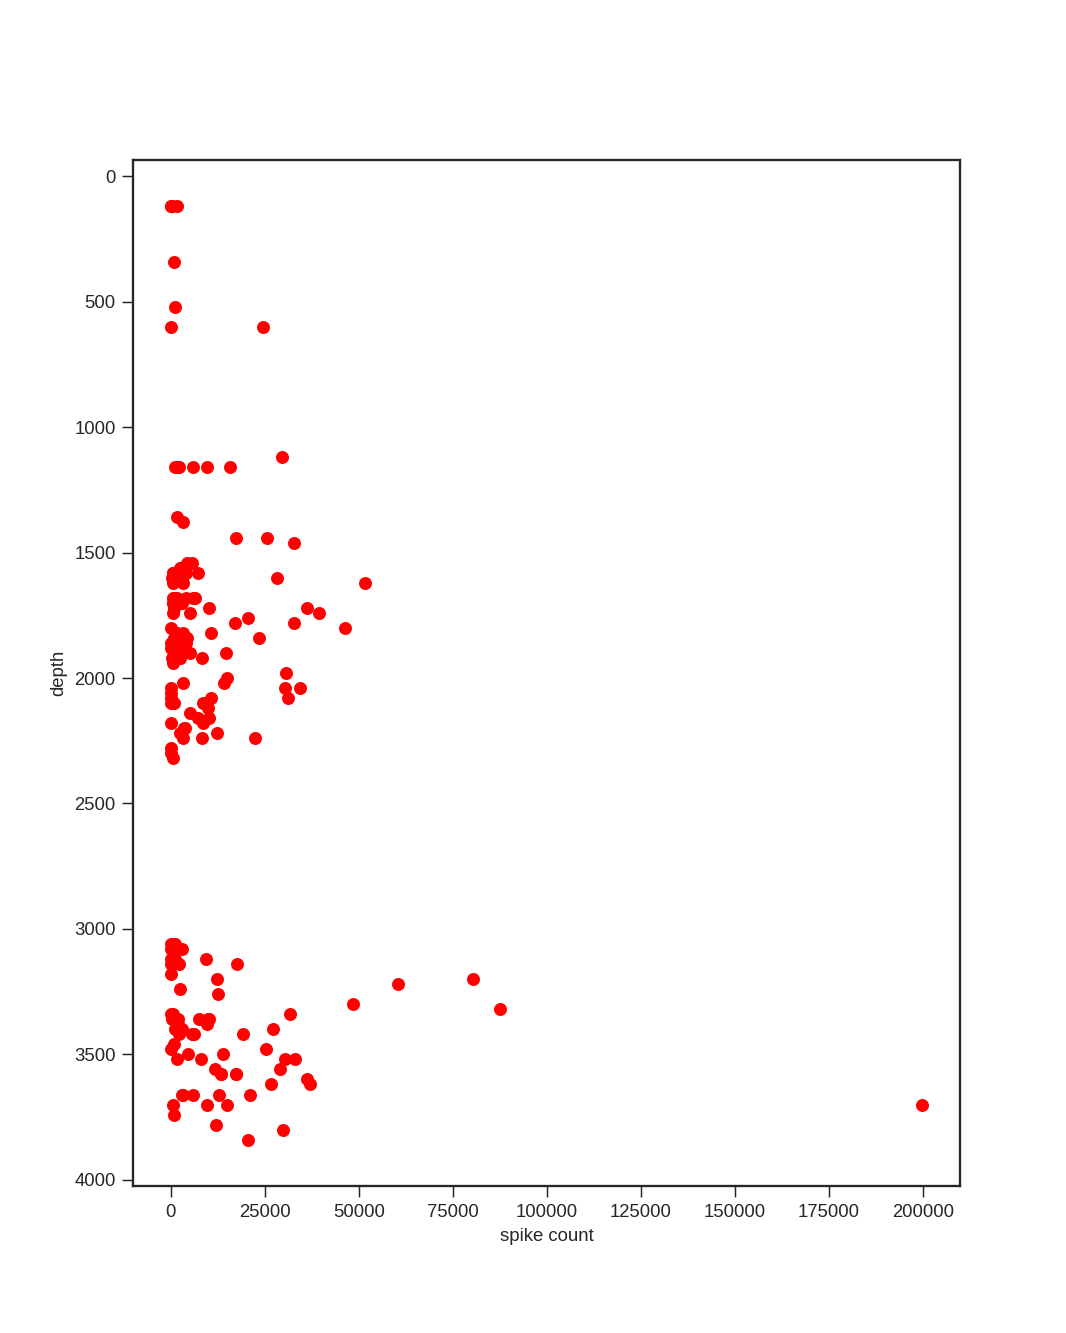

Text(0, 0.5, 'depth')

In [49]:
depth = all_data_good['depth']
n_spk = all_data_good['n_spikes']
plt.rcParams["figure.figsize"] = (8,10)

plt.scatter(n_spk, depth, color='r')
plt.gca().invert_yaxis()
plt.xlabel('spike count')
plt.ylabel('depth')
# plt.savefig('spikecountVSdepth.png')

In [28]:
firing_rate = all_data_good["firing_rate"]
plt.scatter(depth, firing_rate)
plt.xlabel('depth')
plt.ylabel('firing_rate')

Text(50.125, 0.5, 'firing_rate')

In [50]:
depth = data_good['depth']
n_spk = data_good['n_spikes']


# plt.scatter(n_spk, depth)
# plt.xlabel('spike count')
# plt.ylabel('depth')

In [51]:
latsep = all_data_good[data_good['depth']]
depthLS = latsep['depth']
n_spkLS = latsep['n_spikes']

fg, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].scatter(n_spkLS, depthLS)
ax[0].set_xlabel('spike count (lateral septum)')
ax[0].set_ylabel('depth (lateral septum)')

ax[1].scatter(depthLS, n_spkLS)
ax[1].set_xlabel('depth (lateral septum)')
ax[1].set_ylabel('spike count (lateral septum)')


IndexError: arrays used as indices must be of integer (or boolean) type

In [52]:
depth = all_data_good['depth']
n_spk = all_data_good['n_spikes']
id_s = all_data_good['id']
channel=all_data_good['channel']

In [36]:
print(spike_times)


[[6.30000000e-03]
 [6.66666667e-03]
 [7.60000000e-03]
 ...
 [2.50535950e+03]
 [2.50536200e+03]
 [2.50536663e+03]]


In [53]:
cluster_depth = all_data_good['depth']

sort_index = list(sorted(filter(lambda it: cluster_depth[it] > 240,
                               range(len(id_s))), 
                         key=lambda it: cluster_depth[it]))

len(all_data_good)
# print('orginal cluster ID', id_s)
# print(len(id_s))
# print('sorted cluster ID',id_s[sort_index])
# print('depth',all_data_good['depth'][sort_index])
# print('sorted channel ID', channel[sort_index])
# print(len(sort_index))

200

In [56]:
channel_label = []
spike_x = []
spike_y = []
spike_time_range = (300, 360)
plt.rcParams["figure.figsize"] = (20,20)



for y_order, cluster_index in enumerate(sort_index):
    if not (0 <= y_order < 10):
        continue
    channel_id = channel[cluster_index]
       
    channel_label.append(str(channel_id))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == id_s[cluster_index],
        spike_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))
    for spike_t in spike_ts:
        spike_y.append(y_order)
        spike_x.append(spike_t)

# plt.scatter(spike_x, spike_y, marker='|', c='k')
# plt.savefig('rasterplotopenfield.png')
# plt.yticks(np.arange(len(channel_label)), channel_label)
    

<IPython.core.display.Javascript object>


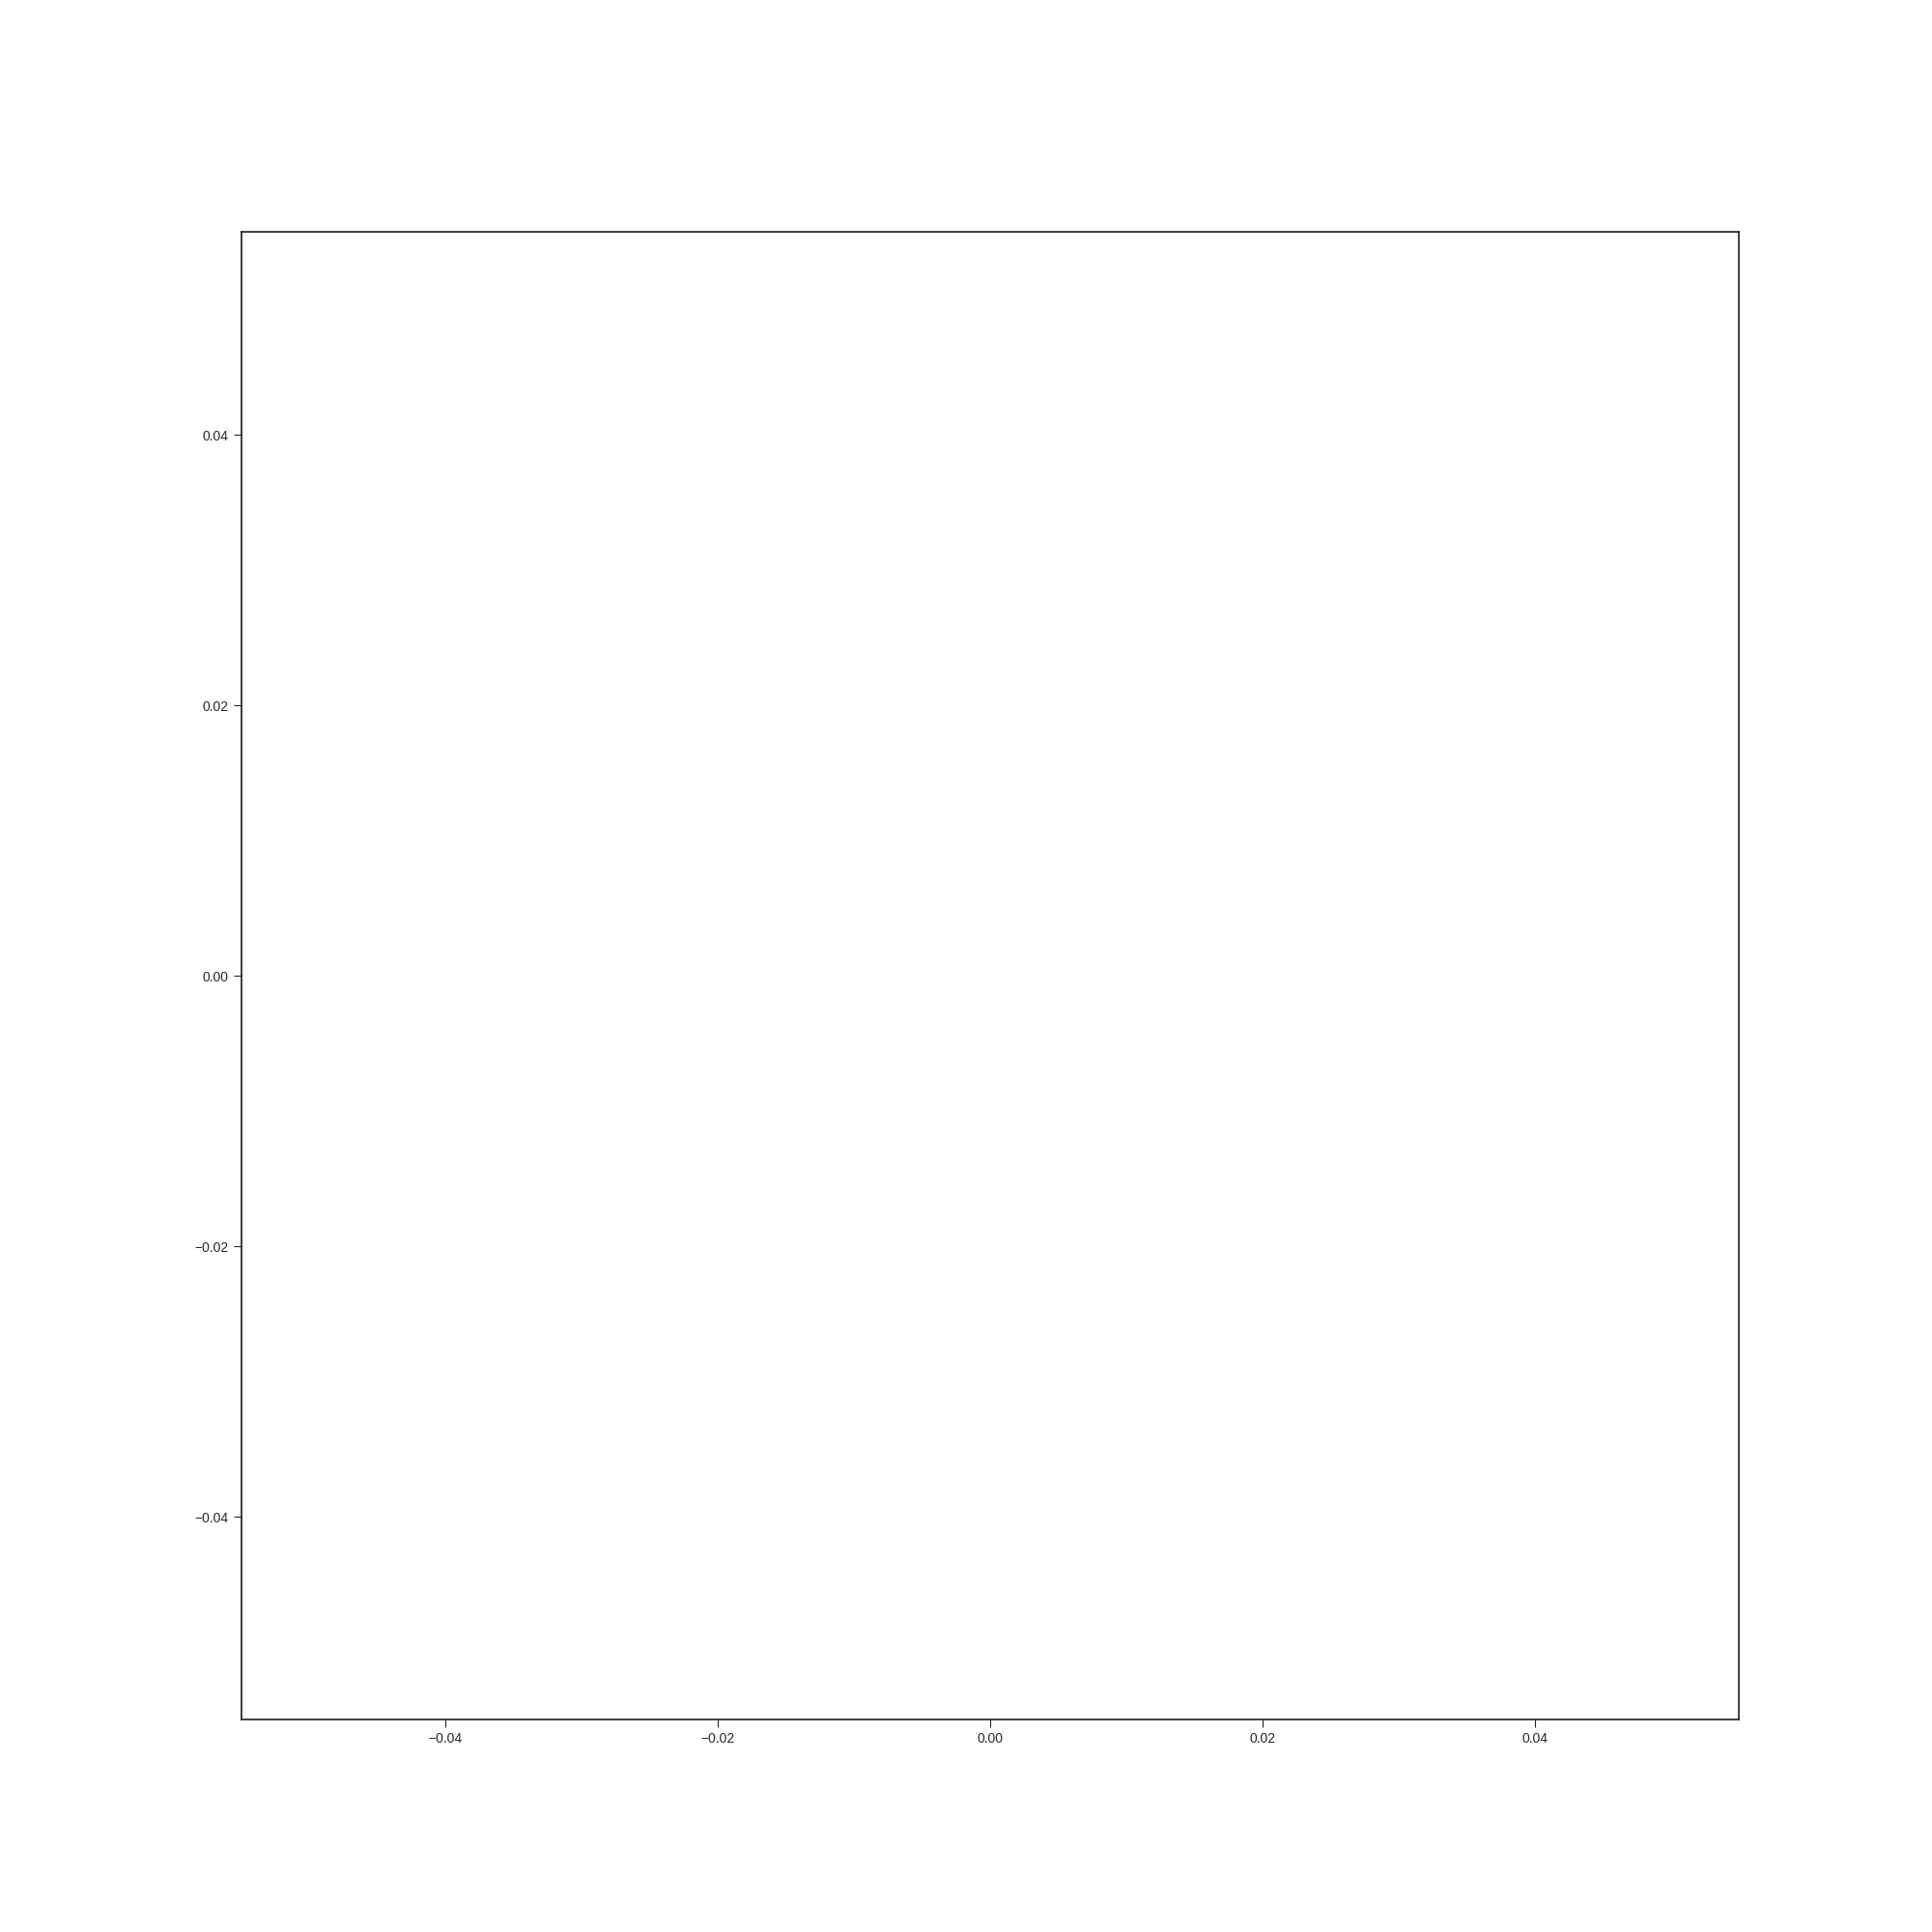

In [40]:
channel_label = []
spike_x = []
spike_y = []
spile_time_range = (2861, 2880)
plt.rcParams["figure.figsize"] = (20,20)

for cluster_index, cluster_id in enumerate(id_s):
    channel_label.append(str(channel[cluster_index]))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))
    for spike_t in spike_ts:
        spike_y.append(cluster_index)
        spike_x.append(spike_t)

plt.scatter(spike_x, spike_y, marker='|', c='k')
plt.savefig('rasterplotlineartrack.png')
#plt.yticks(np.arange(len(channel_label)), channel_label)
    

In [17]:
channel_label = []
spike_x = []
spike_y = []
spile_time_range = (2500, 2560)
plt.rcParams["figure.figsize"] = (20,20)

for cluster_index, cluster_id in enumerate(id_s):
    channel_label.append(str(channel[cluster_index]))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))
    for spike_t in spike_ts:
        spike_y.append(cluster_index)
        spike_x.append(spike_t)

plt.scatter(spike_x, spike_y, marker='|', c='k')
plt.savefig('rasterplotsleepbox.png')
#plt.yticks(np.arange(len(channel_label)), channel_label)
    

In [19]:
print(spike_times.shape)
print(spike_clusters.shape)

(3808357, 1)
(3808357,)


<IPython.core.display.Javascript object>


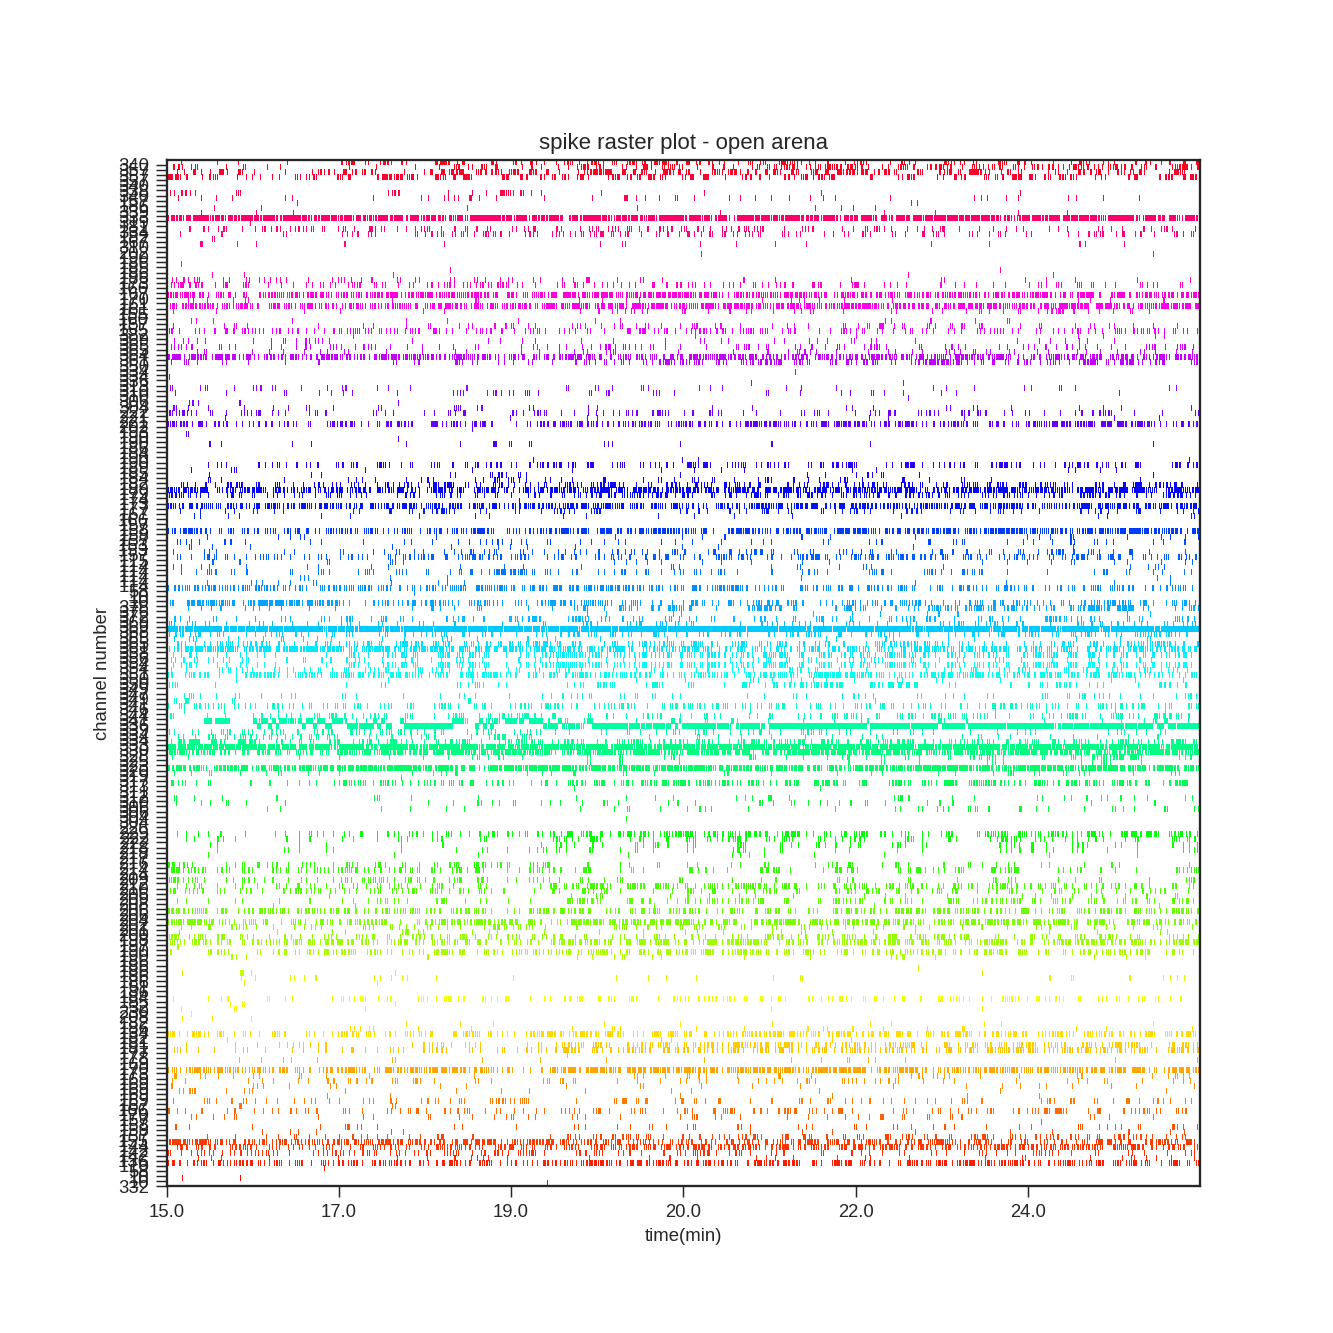

In [55]:
#10 minutes open box
channel_label = []
spike_x = []
spike_y = []
spile_time_range = (920, 1520)
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(id_s):
    channel_label.append(str(channel[cluster_index]))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))

#     for spike_t in spike_ts:
#         spike_y.append(cluster_index)
    spike_x.append(spike_ts)
    
# spike_x = np.array(spike_x)

fklab.plot.plots.plots.plot_raster(spike_x, background_color='white', colormap='hsv', spacing = 1, linewidth=0.1)
plt.xlim(*spile_time_range)
plt.ylim(0, len(channel_label))

x_ticks = np.arange(*spile_time_range, 100)
plt.xticks(x_ticks, np.round(x_ticks / 60, 0))
plt.yticks(np.arange(len(channel_label)), channel_label)

plt.title('spike raster plot - open arena')
plt.ylabel('channel number')
plt.xlabel('time(min)')
plt.savefig("rasterbox.png")

<IPython.core.display.Javascript object>


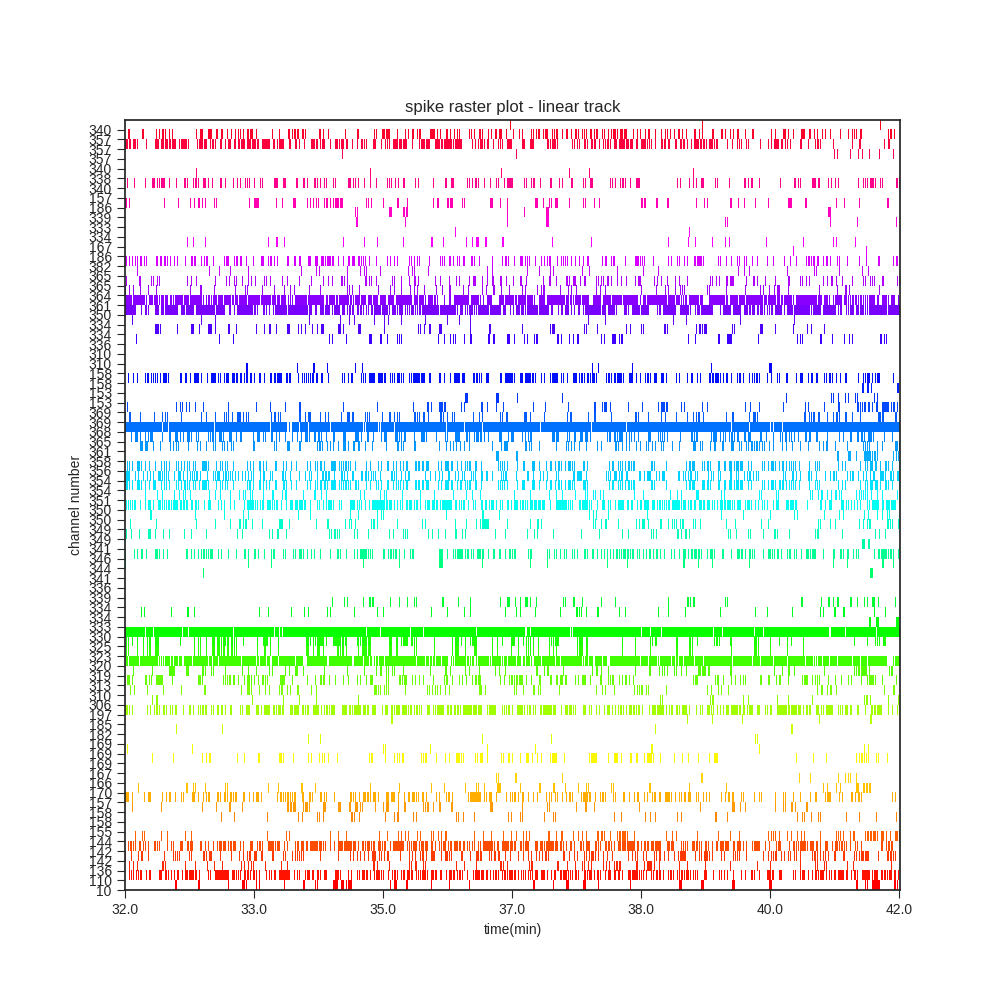

In [21]:
#10 minutes linear track 
channel_label = []
spike_x = []
spike_y = []
spile_time_range = (1897, 2498)
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(id_s):
    channel_label.append(str(channel[cluster_index]))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))

#     for spike_t in spike_ts:
#         spike_y.append(cluster_index)
    spike_x.append(spike_ts)
    
# spike_x = np.array(spike_x)

fklab.plot.plots.plots.plot_raster(spike_x, background_color='white', colormap='hsv', spacing = 1, linewidth=0.1)
plt.xlim(*spile_time_range)
plt.ylim(0, len(channel_label))

x_ticks = np.arange(*spile_time_range, 100)
plt.xticks(x_ticks, np.round(x_ticks / 60, 0))
plt.yticks(np.arange(len(channel_label)), channel_label)

plt.title('spike raster plot - linear track')
plt.ylabel('channel number')
plt.xlabel('time(min)')
plt.savefig("rastertrack.png")


<IPython.core.display.Javascript object>


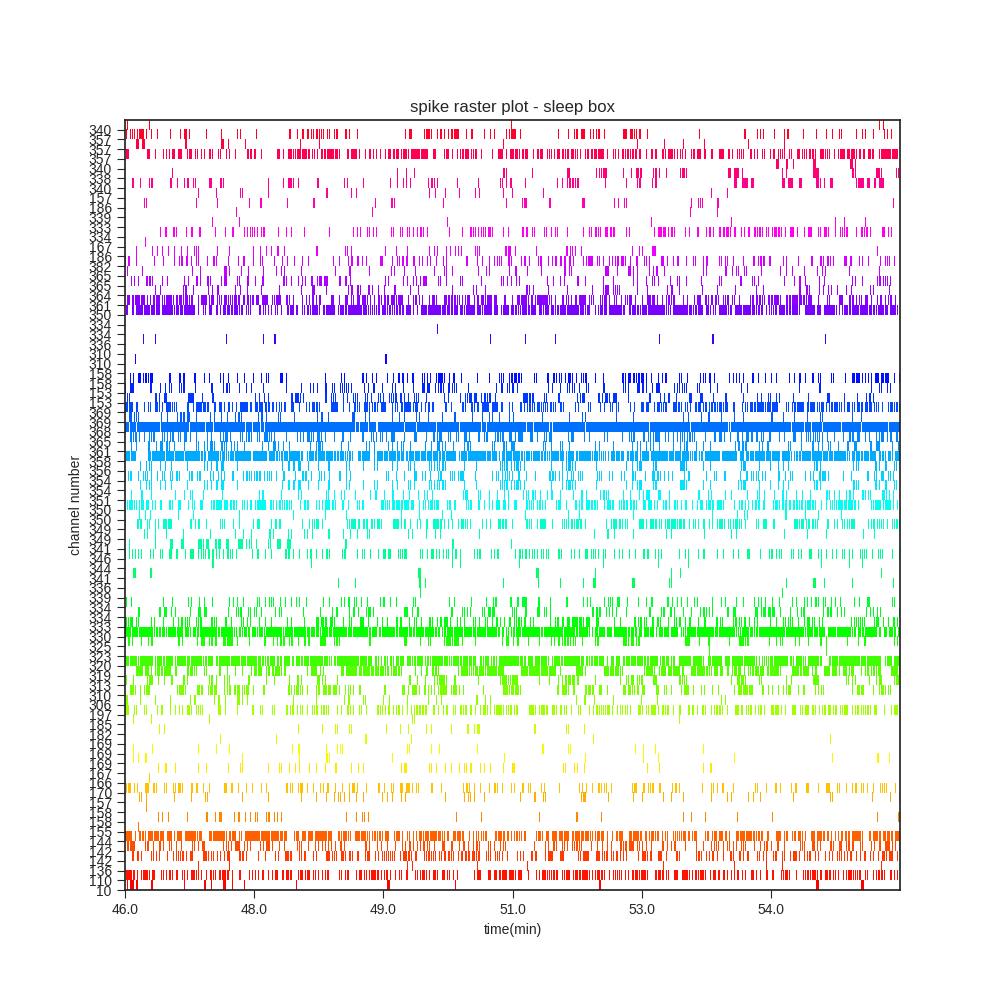

In [22]:
#sleep box
channel_label = []
spike_x = []
spike_y = []
spile_time_range = (2755, 3355)
plt.rcParams["figure.figsize"] = (10,10)

for cluster_index, cluster_id in enumerate(id_s):
    channel_label.append(str(channel[cluster_index]))
    
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    
    # print('cluster', cluster_id, 'n_spike', len(spike_ts))

#     for spike_t in spike_ts:
#         spike_y.append(cluster_index)
    spike_x.append(spike_ts)
    
# spike_x = np.array(spike_x)

fklab.plot.plots.plots.plot_raster(spike_x, background_color='white', colormap='hsv', spacing = 1, linewidth=0.1)
plt.xlim(*spile_time_range)
plt.ylim(0, len(channel_label))

x_ticks = np.arange(*spile_time_range, 100)
plt.xticks(x_ticks, np.round(x_ticks / 60, 0))
plt.yticks(np.arange(len(channel_label)), channel_label)

plt.title('spike raster plot - sleep box')
plt.ylabel('channel number')
plt.xlabel('time(min)')
plt.savefig("rastersleep.png")

<IPython.core.display.Javascript object>


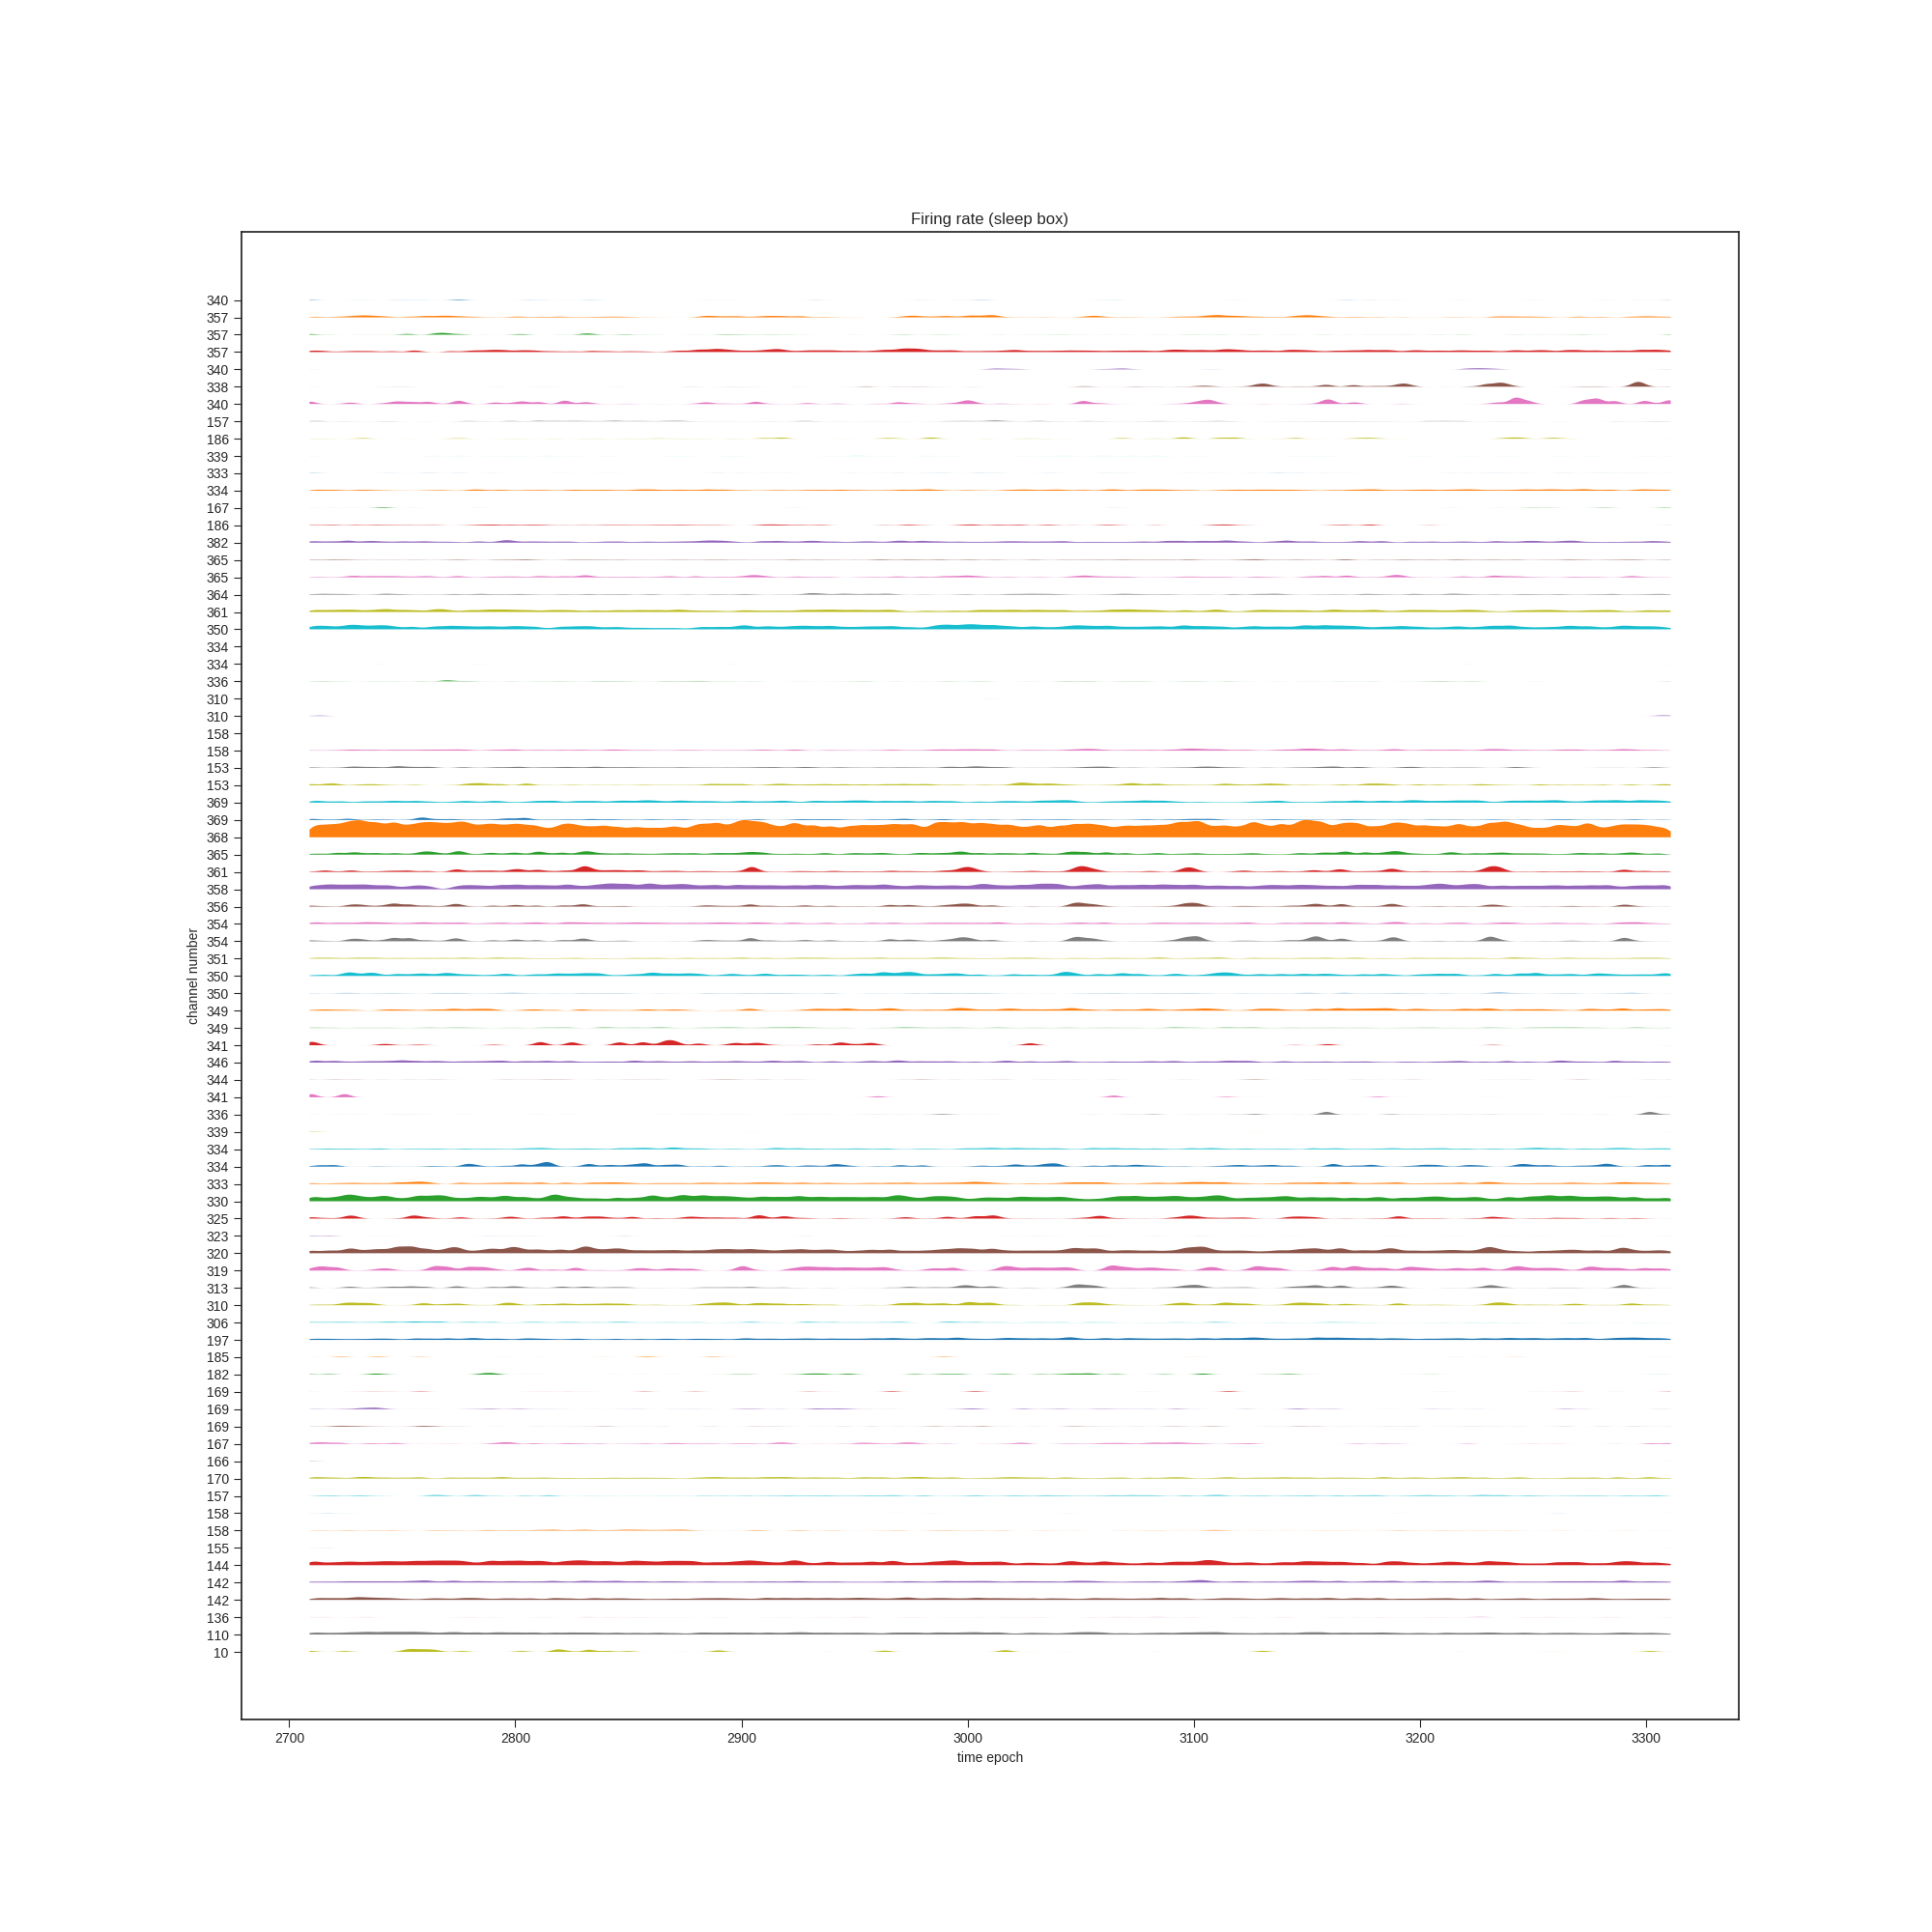

In [29]:
import scipy

import fklab.signals.smooth as smooth

#create kernel
K = smooth.GaussianKernel( bandwidth = 0.5 ) #0.5 second bandwidth

#create smoother object
S = smooth.Smoother( kernel=K )

channel_label = []
fr_data = []
spile_time_range = (2709, 3311)
plt.rcParams["figure.figsize"] = (20,20)
max_fr_value = 0

for cluster_index, cluster_id in enumerate(id_s):
    
#     if not (10 <= channel[cluster_index] <= 186 ):
#         continue
        
    channel_label.append(str(channel[cluster_index]))
        
    spike_ts = spike_times[np.logical_and.reduce((
        spike_clusters == cluster_id,
        spile_time_range[0] <= spike_times[:, 0],
        spike_times[:, 0] <= spile_time_range[1]
    )), 0]
    
    if len(spike_ts) > 0:
        binned = scipy.stats.binned_statistic(spike_ts, np.ones_like(spike_ts), 
                                               statistic='count',
                                               bins=(spile_time_range[1] - spile_time_range[0]), 
                                               range=None)[0]

        smoothed = S(binned,delta=0.2)
        max_fr_value = max(max_fr_value, np.max(smoothed))
    else:
        smoothed = np.zeros(shape=(spile_time_range[1] - spile_time_range[0],))
        
    fr_data.append(smoothed)
    
t = np.linspace(spile_time_range[0], spile_time_range[1], 
                num=(spile_time_range[1] - spile_time_range[0]))
    
for cluster_index, smoothed in enumerate(reversed(fr_data)):
    cluster_index = len(fr_data) - cluster_index - 1
    smoothed = (1 * smoothed / max_fr_value) + cluster_index
    
#     plt.plot(smoothed)
    plt.fill_between(t, smoothed, np.zeros_like(smoothed) + cluster_index)
    
plt.yticks(np.arange(len(channel_label)), channel_label)
plt.ylabel('channel number')
plt.xlabel('time epoch')
plt.title("Firing rate (sleep box)")
plt.savefig('firingratesleepbox.png')